In [1]:
!pip install pillow numpy matplotlib

In [2]:
import numpy as np
from PIL import Image
from pprint import pprint

def read_image(image_path):
    return Image.open(image_path)


def read_bounding_boxes(data_path):
    bounding_boxes = []
    with open(data_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                bbox = {
                    'x1': int(parts[0]),
                    'y1': int(parts[1]),
                    'w': int(parts[2]),
                    'h': int(parts[3]),
                    'label': parts[4]
                }
                bounding_boxes.append(bbox)
    return bounding_boxes


def read_predictions(pred_path):
    predictions = []
    with open(pred_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 6:
                prediction = {
                    'x1': int(parts[0]),
                    'y1': int(parts[1]),
                    'w': int(parts[2]),
                    'h': int(parts[3]),
                    'label': parts[4],
                    'probability': float(parts[5])
                }
                predictions.append(prediction)
    return predictions

In [3]:
image_path = 'od_data/pedestrian-hit-by-car.png'
gt_path = 'od_data/groundtruth.txt'
pred_path = 'od_data/predictions.txt'

image = read_image(image_path)
original_size = image.size

gt_bboxes = read_bounding_boxes(gt_path)
pred_bboxes = read_predictions(pred_path)

# Output the results
print("Image size:", image.size)
for gt_bbox in gt_bboxes:
    print(gt_bbox)

print("\nPredictions:")
for pred_bbox in pred_bboxes:
    print(pred_bbox)

Image size: (952, 484)
{'x1': 110, 'y1': 180, 'w': 80, 'h': 150, 'label': 'pedestrian'}
{'x1': 390, 'y1': 200, 'w': 360, 'h': 160, 'label': 'car'}

Predictions:
{'x1': 107, 'y1': 174, 'w': 119, 'h': 122, 'label': 'pedestrian', 'probability': 0.57}
{'x1': 391, 'y1': 204, 'w': 299, 'h': 230, 'label': 'car', 'probability': 0.98}
{'x1': 110, 'y1': 175, 'w': 45, 'h': 101, 'label': 'pedestrian', 'probability': 0.6}
{'x1': 387, 'y1': 204, 'w': 256, 'h': 166, 'label': 'car', 'probability': 0.73}
{'x1': 109, 'y1': 182, 'w': 84, 'h': 182, 'label': 'pedestrian', 'probability': 0.91}
{'x1': 385, 'y1': 203, 'w': 273, 'h': 152, 'label': 'car', 'probability': 0.94}
{'x1': 105, 'y1': 182, 'w': 58, 'h': 114, 'label': 'pedestrian', 'probability': 0.74}
{'x1': 393, 'y1': 195, 'w': 196, 'h': 127, 'label': 'car', 'probability': 0.62}
{'x1': 112, 'y1': 181, 'w': 42, 'h': 151, 'label': 'pedestrian', 'probability': 0.43}
{'x1': 393, 'y1': 202, 'w': 428, 'h': 171, 'label': 'car', 'probability': 0.58}
{'x1': 10

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_bboxes(image, gt_boxes, pred_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot ground truth bounding boxes
    for bbox in gt_boxes:
        rect = patches.Rectangle((bbox['x1'] - bbox['w'] // 2, bbox['y1'] - bbox['h'] // 2), bbox['w'], bbox['h'], 
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

    # Plot predicted bounding boxes
    for pred in pred_boxes:
        rect = patches.Rectangle((pred['x1'] - pred['w'] // 2, pred['y1'] - pred['h'] // 2), pred['w'], pred['h'], 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

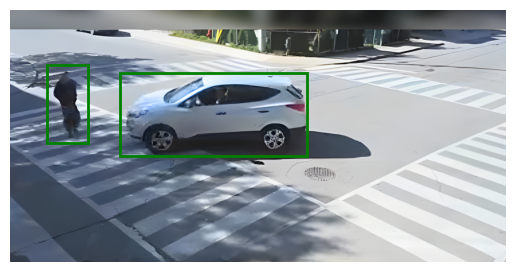

In [5]:
visualize_bboxes(image, gt_bboxes, [])

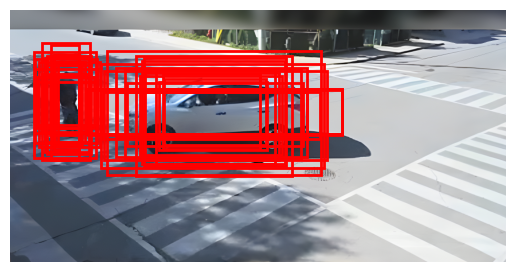

In [6]:
visualize_bboxes(image, [], pred_bboxes)

In [7]:
def resize_image(image, target_size=(448, 448)):
    return image.resize(target_size, Image.Resampling.LANCZOS)

In [8]:
def scale_bboxes(bboxes, original_size, new_size):
    scaled_bboxes = []
    x_scale = new_size[0] / original_size[0]
    y_scale = new_size[1] / original_size[1]

    for bbox in bboxes:
        scaled_bbox = {
            'x1': int(bbox['x1'] * x_scale),
            'y1': int(bbox['y1'] * y_scale),
            'w': int(bbox['w'] * x_scale),
            'h': int(bbox['h'] * y_scale),
            'label': bbox['label']
        }
        if 'probability' in bbox:
            scaled_bbox['probability'] = bbox['probability']
        scaled_bboxes.append(scaled_bbox)
    
    return scaled_bboxes

In [9]:
target_size = (448, 448)
grid_size = (7, 7)

# Resize image
resized_image = resize_image(image, target_size=target_size)
new_size = resized_image.size

scaled_gt_boxes = scale_bboxes(gt_bboxes, original_size, new_size)
scaled_pred_boxes = scale_bboxes(pred_bboxes, original_size, new_size)

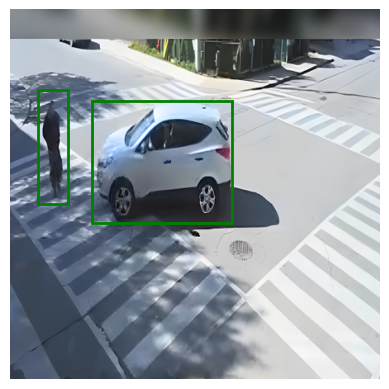

In [10]:
visualize_bboxes(resized_image, scaled_gt_boxes, [])

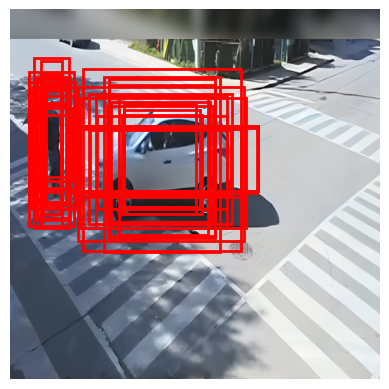

In [11]:
visualize_bboxes(resized_image, [], scaled_pred_boxes)

In [12]:
def normalize_image(image):
    image_array = np.asarray(image)
    normalized_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
    return normalized_image

0.0 1.0 0.5836479839331566


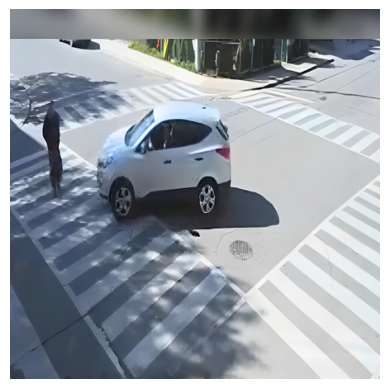

In [13]:
# Normalize image
normalized_image = normalize_image(resized_image)

print(normalized_image.min(), normalized_image.max(), normalized_image.mean())

visualize_bboxes(resized_image, [], [])

In [14]:
def split_image_to_grid(image, grid_size=(7, 7)):
    width, height = image.size
    grid_cells = []

    cell_width = width // grid_size[1]
    cell_height = height // grid_size[0]

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            x1 = col * cell_width
            y1 = row * cell_height
            x2 = x1 + cell_width
            y2 = y1 + cell_height
            grid_cells.append((x1, y1, x2, y2))

    return grid_cells

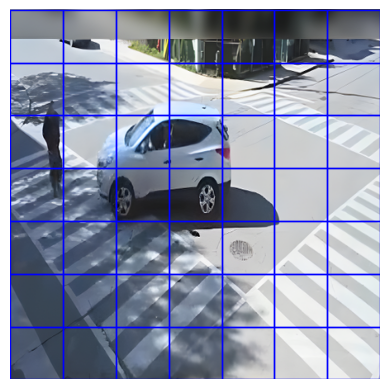

In [15]:
def visualize_grid(image, grid_cells):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for cell in grid_cells:
        x1, y1, x2, y2 = cell
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


grid_cells = split_image_to_grid(resized_image, grid_size=grid_size)
visualize_grid(resized_image, grid_cells)

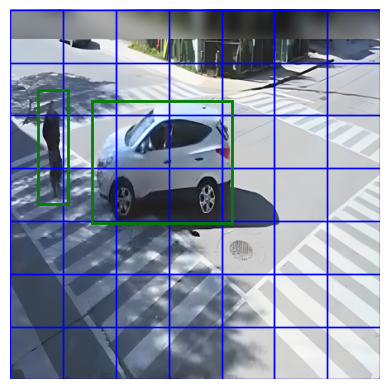

In [16]:
def visualize_grid_with_bboxes(image, grid_cells, gt_boxes, pred_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot grid cells
    for cell in grid_cells:
        x1, y1, x2, y2 = cell
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    # Plot ground truth bounding boxes
    for bbox in gt_boxes:
        rect = patches.Rectangle((bbox['x1'] - bbox['w'] // 2, bbox['y1'] - bbox['h'] // 2), bbox['w'], bbox['h'], 
                                 linewidth=2, edgecolor='green', facecolor='none', label='GT: ' + bbox['label'])
        ax.add_patch(rect)

    # Plot predicted bounding boxes
    for pred in pred_boxes:
        rect = patches.Rectangle((pred['x1'] - pred['w'] // 2, pred['y1'] - pred['h'] // 2), pred['w'], pred['h'], 
                                 linewidth=2, edgecolor='red', facecolor='none', label='Pred: ' + pred['label'] + ' (' + str(pred['probability']) + ')')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


visualize_grid_with_bboxes(normalized_image, grid_cells, scaled_gt_boxes, [])

In [17]:
def create_binary_map(image_size, grid_size, gt_boxes):
    width, height = image_size
    rows, cols = grid_size

    # Initialize the binary map
    binary_map = np.zeros((rows, cols), dtype=int)

    # Calculate cell dimensions
    cell_width = width // cols
    cell_height = height // rows

    # Iterate over each GT bbox
    for bbox in gt_boxes:
        # Calculate the center of the bbox
        center_x = bbox['x1']
        center_y = bbox['y1']

        # Determine the grid cell the center falls into
        col_idx = center_x // cell_width
        row_idx = center_y // cell_height

        # Set the corresponding cell in the binary map to 1
        if 0 <= row_idx < rows and 0 <= col_idx < cols:
            binary_map[row_idx, col_idx] = 1

    return binary_map


def visualize_binary_map(binary_map):
    plt.figure(figsize=(7, 7))
    plt.imshow(binary_map, cmap='gray', interpolation='nearest')
    plt.title('Binary Map')
    plt.colorbar(label='Value')
    plt.show()

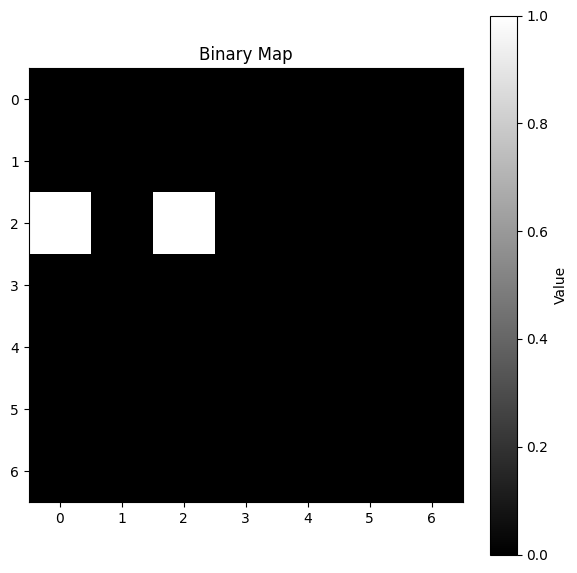

In [18]:
binary_map = create_binary_map(new_size, grid_size, scaled_gt_boxes)

visualize_binary_map(binary_map)

In [19]:
def overlay_binary_map(image, binary_map, grid_cells, gt_boxes, pred_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image, alpha=0.7)

    # Overlay binary map
    rows, cols = binary_map.shape
    for row in range(rows):
        for col in range(cols):
            if binary_map[row, col] == 1:
                x1, y1, x2, y2 = grid_cells[row * cols + col]
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='yellow', facecolor='yellow', alpha=0.8)
                ax.add_patch(rect)

    # Plot grid cells
    for cell in grid_cells:
        x1, y1, x2, y2 = cell
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    # Plot ground truth bounding boxes
    for bbox in gt_boxes:
        rect = patches.Rectangle((bbox['x1'] - bbox['w'] // 2, bbox['y1'] - bbox['h'] // 2), bbox['w'], bbox['h'], 
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

    # Plot predicted bounding boxes
    for pred in pred_boxes:
        rect = patches.Rectangle((pred['x1'] - pred['w'] // 2, pred['y1'] - pred['h'] // 2), pred['w'], pred['h'], 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

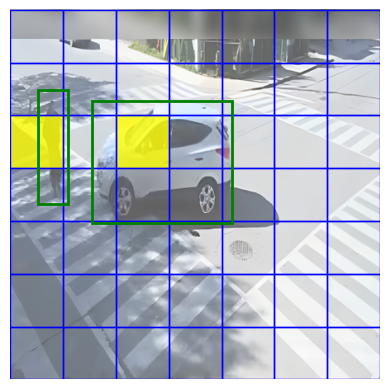

In [20]:
overlay_binary_map(normalized_image, binary_map, grid_cells, scaled_gt_boxes, [])

In [21]:
def create_regression_map(image_size, grid_size, gt_boxes):
    rows, cols = grid_size
    regression_map = np.zeros((rows, cols, 5))

    width, height = image_size
    cell_width = width // cols
    cell_height = height // rows

    class_mapping = {'pedestrian': 0, 'car': 1}

    for bbox in gt_boxes:
        center_x = bbox['x1']
        center_y = bbox['y1']

        col_idx = center_x // cell_width
        row_idx = center_y // cell_height

        if 0 <= row_idx < rows and 0 <= col_idx < cols:
            regression_map[row_idx, col_idx] = [
                bbox['x1'], bbox['y1'], bbox['w'], bbox['h'], class_mapping[bbox['label']]
            ]

    return regression_map


def plot_regression_map(reg_map, reg_map_name):
    plt.figure(figsize=(7, 7))
    plt.imshow(reg_map, cmap='gray')
    plt.axis('off')
    plt.title(reg_map_name)
    plt.colorbar(label='values')
    plt.show()

regression_map.shape (7, 7, 5)


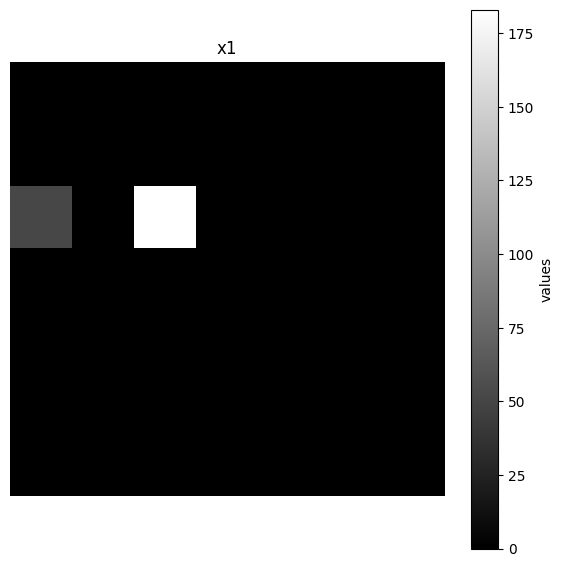

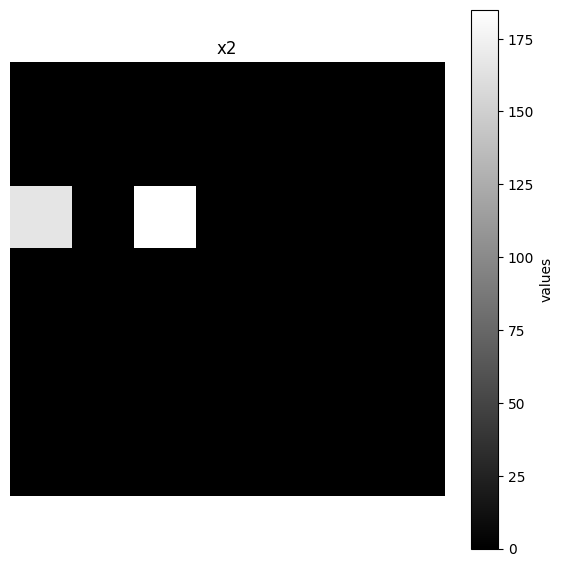

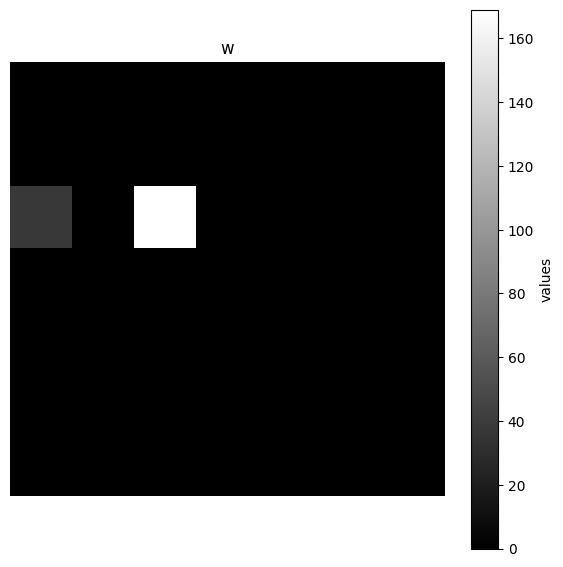

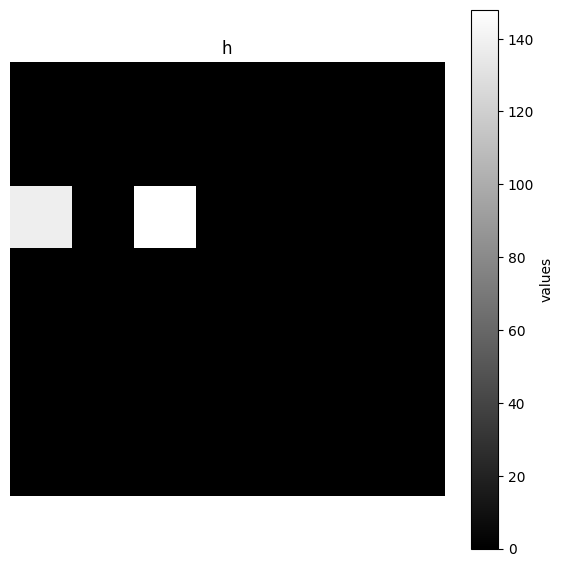

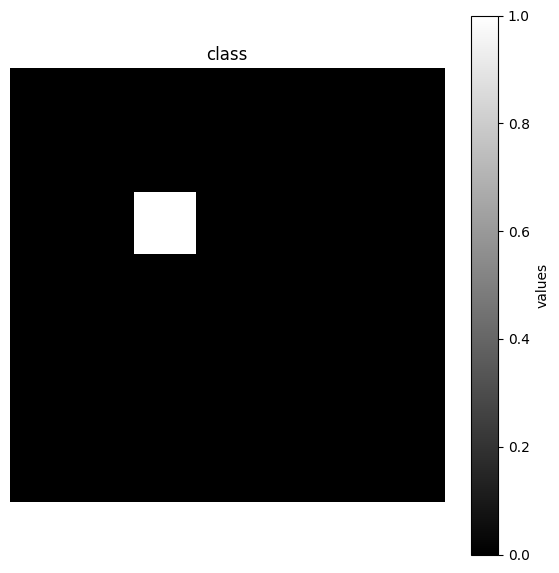

In [22]:
regression_map = create_regression_map(new_size, (7, 7), scaled_gt_boxes)

print('regression_map.shape', regression_map.shape)

# Visualize regression map
plot_regression_map(regression_map[:,:,0], 'x1')

plot_regression_map(regression_map[:,:,1], 'x2')

plot_regression_map(regression_map[:,:,2], 'w')

plot_regression_map(regression_map[:,:,3], 'h')

plot_regression_map(regression_map[:,:,4], 'class')

In [23]:
def create_normalized_regression_map(image_size, grid_size, gt_boxes):
    rows, cols = grid_size
    regression_map = np.zeros((rows, cols, 5))

    width, height = image_size
    cell_width = width // cols
    cell_height = height // rows

    class_mapping = {'pedestrian': 0, 'car': 1}

    for bbox in gt_boxes:
        center_x = bbox['x1']
        center_y = bbox['y1']

        col_idx = center_x // cell_width
        row_idx = center_y // cell_height

        if 0 <= row_idx < rows and 0 <= col_idx < cols:
            regression_map[row_idx, col_idx] = [
                bbox['x1'] / width, 
                bbox['y1'] / height, 
                np.log(bbox['w']), 
                np.log(bbox['h']), 
                class_mapping[bbox['label']]
            ]

    return regression_map

normalized_regression_map.shape (7, 7, 5)


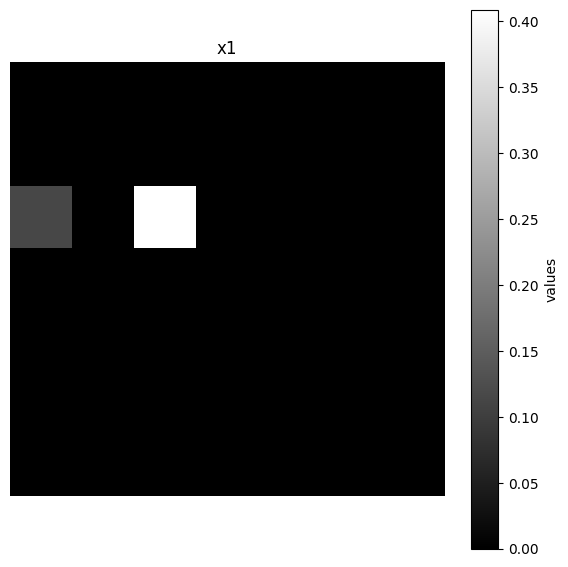

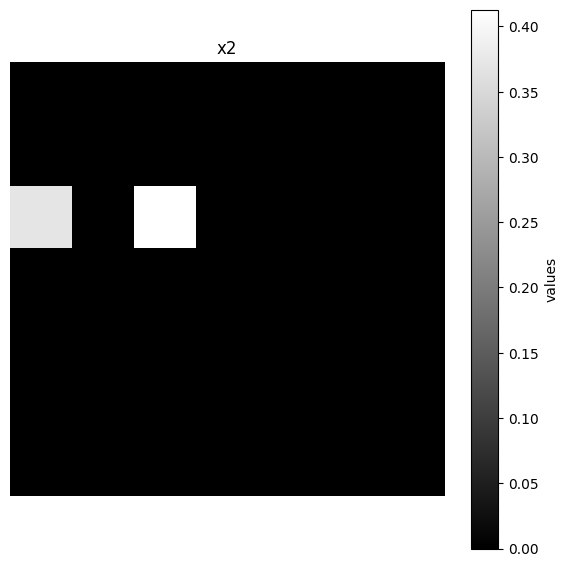

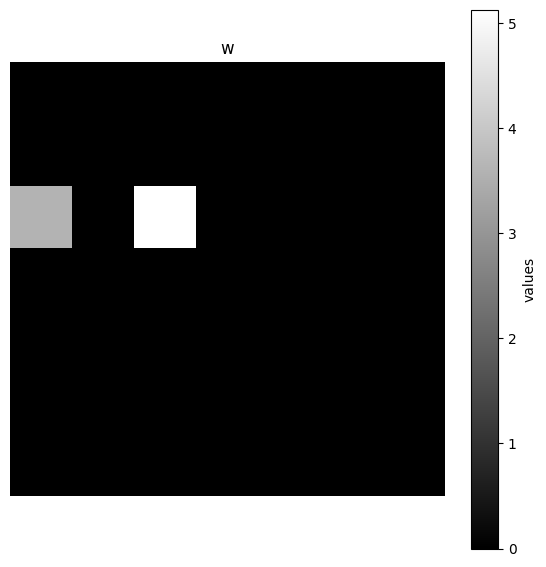

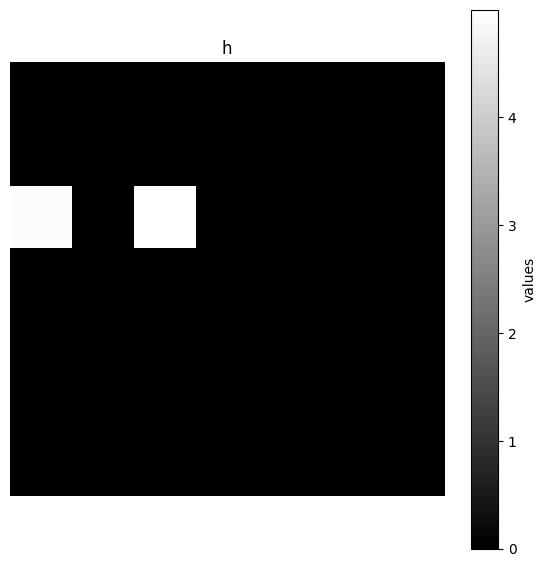

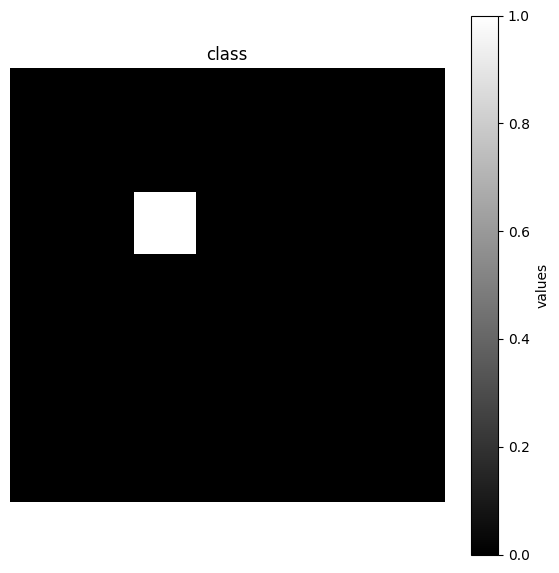

In [24]:
normalized_regression_map = create_normalized_regression_map(new_size, (7, 7), scaled_gt_boxes)

'''
Stabilize the learning process
Better handling of scale variations
'''

print('normalized_regression_map.shape', normalized_regression_map.shape)

# Visualize regression map
plot_regression_map(normalized_regression_map[:,:,0], 'x1')

plot_regression_map(normalized_regression_map[:,:,1], 'x2')

plot_regression_map(normalized_regression_map[:,:,2], 'w')

plot_regression_map(normalized_regression_map[:,:,3], 'h')

plot_regression_map(normalized_regression_map[:,:,4], 'class')

[{'h': 138, 'label': 'pedestrian', 'w': 36, 'x1': 51, 'y1': 166},
 {'h': 147, 'label': 'car', 'w': 169, 'x1': 183, 'y1': 185}]
[{'h': 138, 'label': 'pedestrian', 'w': 37, 'x1': 51, 'y1': 166},
 {'h': 148, 'label': 'car', 'w': 169, 'x1': 183, 'y1': 185}]


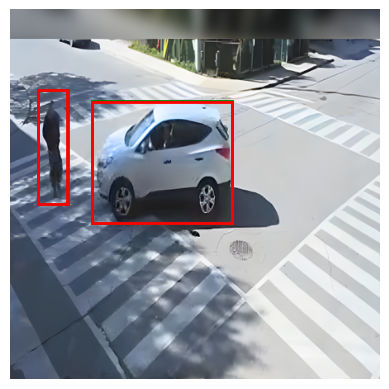

In [25]:
def decode_bounding_boxes(image_size, grid_size, binary_map, regression_map):
    rows, cols = grid_size
    width, height = image_size
    decoded_bboxes = []

    class_mapping = {0: 'pedestrian', 1: 'car'}

    for row in range(rows):
        for col in range(cols):
            if binary_map[row, col] == 1:
                x1_norm, y1_norm, log_w, log_h, cls = regression_map[row, col]
                x1 = int(x1_norm * width)
                y1 = int(y1_norm * height)
                w = int(np.exp(log_w))
                h = int(np.exp(log_h))
                label = class_mapping[int(cls)]

                decoded_bbox = {
                    'x1': x1,
                    'y1': y1,
                    'w': w,
                    'h': h,
                    'label': label
                }
                decoded_bboxes.append(decoded_bbox)

    return decoded_bboxes

decoded_bboxes = decode_bounding_boxes(target_size, grid_size, binary_map, normalized_regression_map)
pprint(decoded_bboxes)
pprint(scaled_gt_boxes)
visualize_bboxes(resized_image, scaled_gt_boxes, decoded_bboxes)

In [26]:
'''
(x1_1,y1_1)
|
v
--------
|      |
|      |
|   ---|----
----|---   |
    |      |
    |      |
    --------
           ^
           |
        (x2_2,y2_2)

compute the maximum of both top left corners
and the minimum of both bottom right corners
if these coordinates form a valid rectangle
we compute the area of this rectangle
'''
def calculate_iou(bbox1, bbox2):
    x1_1, y1_1, w1, h1 = bbox1['x1'], bbox1['y1'], bbox1['w'], bbox1['h']
    x2_1, y2_1 = x1_1 + w1, y1_1 + h1

    x1_2, y1_2, w2, h2 = bbox2['x1'], bbox2['y1'], bbox2['w'], bbox2['h']
    x2_2, y2_2 = x1_2 + w2, y1_2 + h2

    # Calculate intersection
    inter_x1 = max(x1_1, x1_2)
    inter_y1 = max(y1_1, y1_2)
    inter_x2 = min(x2_1, x2_2)
    inter_y2 = min(y2_1, y2_2)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    else:
        inter_area = 0

    # Calculate areas
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate union
    union_area = area1 + area2 - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

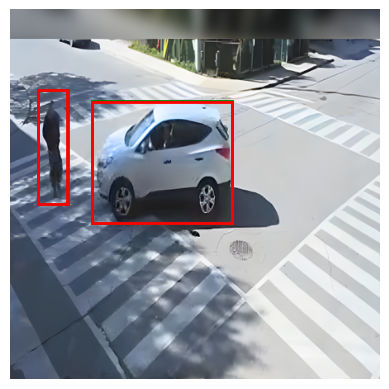

iou= 0.972972972972973
iou= 0.9932432432432432
iou= 0.0
iou= 0.0


In [27]:
visualize_bboxes(resized_image, scaled_gt_boxes, decoded_bboxes)

iou = calculate_iou(scaled_gt_boxes[0], decoded_bboxes[0])
print('iou=', iou)

iou = calculate_iou(scaled_gt_boxes[1], decoded_bboxes[1])
print('iou=', iou)

iou = calculate_iou(scaled_gt_boxes[0], decoded_bboxes[1])
print('iou=', iou)

iou = calculate_iou(scaled_gt_boxes[1], decoded_bboxes[0])
print('iou=', iou)

In [50]:
def non_maximum_suppression(predicted_bboxes, iou_threshold=0.5):
    if len(predicted_bboxes) == 0:
        return []

    # Convert list of bboxes to array for easier manipulation
    bboxes = np.array([[bbox['x1'], bbox['y1'], bbox['w'], bbox['h'], bbox['probability']] for bbox in predicted_bboxes])
    labels = np.array([bbox['label'] for bbox in predicted_bboxes])

    # Sort the bounding boxes by confidence score in descending order
    indices = np.argsort(-bboxes[:, 4])
    bboxes = bboxes[indices]
    labels = labels[indices]

    keep = []

    while len(bboxes) > 0:
        # Select the bounding box with the highest confidence score
        current_bbox = bboxes[0]
        current_label = labels[0]
        keep.append({
            'x1': current_bbox[0],
            'y1': current_bbox[1],
            'w': current_bbox[2],
            'h': current_bbox[3],
            'probability': current_bbox[4],
            'label': current_label
        })

        if len(bboxes) == 1:
            break

        # Compute IoU between the current bbox and the remaining bboxes
        remaining_bboxes = bboxes[1:]
        iou = compute_iou(current_bbox, remaining_bboxes)

        # Keep only the bboxes with IoU less than the threshold
        mask = iou < iou_threshold
        bboxes = remaining_bboxes[mask]
        labels = labels[1:][mask]

    return keep

def compute_iou(bbox1, bboxes):
    x1 = np.maximum(bbox1[0], bboxes[:, 0])
    y1 = np.maximum(bbox1[1], bboxes[:, 1])
    x2 = np.minimum(bbox1[0] + bbox1[2], bboxes[:, 0] + bboxes[:, 2])
    y2 = np.minimum(bbox1[1] + bbox1[3], bboxes[:, 1] + bboxes[:, 3])

    inter_area = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    bbox1_area = bbox1[2] * bbox1[3]
    bboxes_area = bboxes[:, 2] * bboxes[:, 3]

    iou = inter_area / (bbox1_area + bboxes_area - inter_area)
    return iou

len(nms_bboxes) 2 len(scaled_pred_boxes) 40


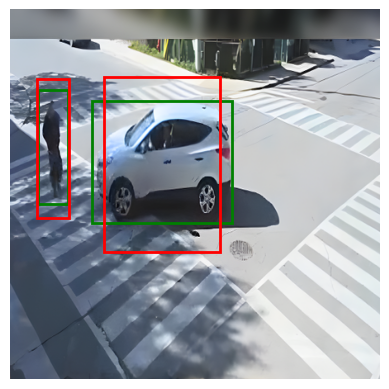

In [51]:
nms_bboxes = non_maximum_suppression(scaled_pred_boxes, iou_threshold=0.2)
print('len(nms_bboxes)', len(nms_bboxes), 'len(scaled_pred_boxes)', len(scaled_pred_boxes))
visualize_bboxes(resized_image, scaled_gt_boxes, nms_bboxes)

len(nms_bboxes) 2 len(scaled_pred_boxes) 40
[{'h': 212.0,
  'label': 'car',
  'probability': 0.98,
  'w': 140.0,
  'x1': 184.0,
  'y1': 188.0},
 {'h': 168.0,
  'label': 'pedestrian',
  'probability': 0.91,
  'w': 39.0,
  'x1': 51.0,
  'y1': 168.0}]


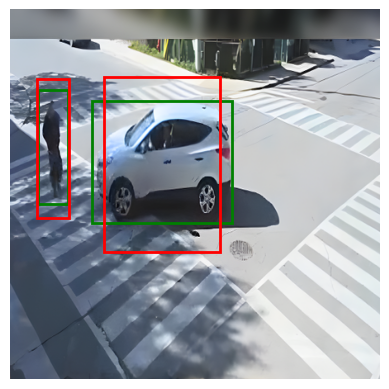

In [52]:
nms_bboxes = non_maximum_suppression(scaled_pred_boxes, iou_threshold=0.25)
print('len(nms_bboxes)', len(nms_bboxes), 'len(scaled_pred_boxes)', len(scaled_pred_boxes))
pprint(nms_bboxes)
visualize_bboxes(resized_image, scaled_gt_boxes, nms_bboxes)

threshold 0.0 precision 0.05 recall 1.0
threshold 0.05 precision 0.05 recall 1.0
threshold 0.1 precision 0.05 recall 1.0
threshold 0.15000000000000002 precision 0.05 recall 1.0
threshold 0.2 precision 0.05 recall 1.0
threshold 0.25 precision 0.05405405405405406 recall 1.0
threshold 0.30000000000000004 precision 0.058823529411764705 recall 1.0
threshold 0.35000000000000003 precision 0.06666666666666667 recall 1.0
threshold 0.4 precision 0.06896551724137931 recall 1.0
threshold 0.45 precision 0.09090909090909091 recall 1.0
threshold 0.5 precision 0.1 recall 1.0
threshold 0.55 precision 0.14285714285714285 recall 1.0
threshold 0.6000000000000001 precision 0.2222222222222222 recall 1.0
threshold 0.65 precision 0.2857142857142857 recall 1.0
threshold 0.7000000000000001 precision 0.2857142857142857 recall 1.0
threshold 0.75 precision 0.5 recall 1.0
threshold 0.8 precision 0.6666666666666666 recall 1.0
threshold 0.8500000000000001 precision 0.6666666666666666 recall 1.0
threshold 0.9 precisio

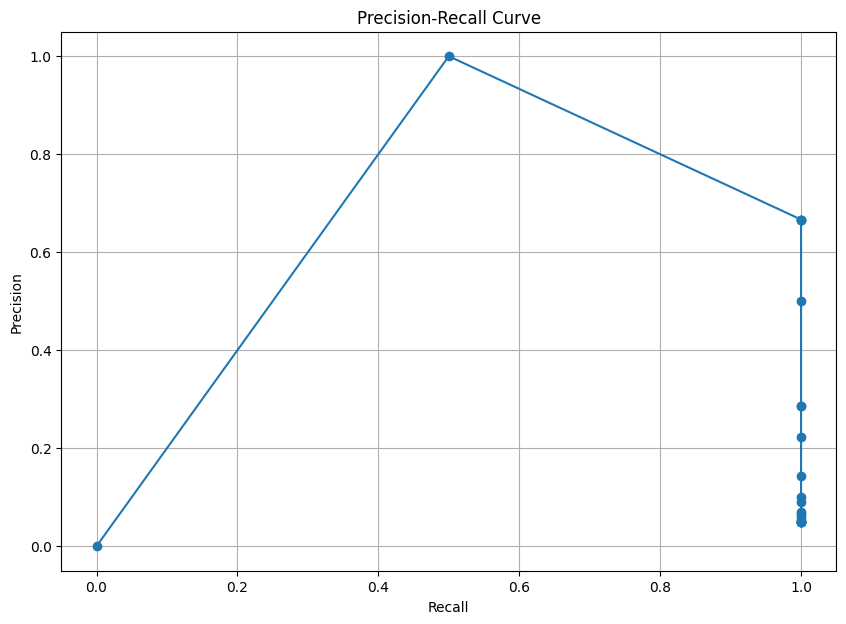

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

def compute_iou_single(bbox1, bbox2):
    x1_1, y1_1 = bbox1['x1'] - bbox1['w'] / 2, bbox1['y1'] - bbox1['h'] / 2
    x2_1, y2_1 = bbox1['x1'] + bbox1['w'] / 2, bbox1['y1'] + bbox1['h'] / 2
    x1_2, y1_2 = bbox2['x1'] - bbox2['w'] / 2, bbox2['y1'] - bbox2['h'] / 2
    x2_2, y2_2 = bbox2['x1'] + bbox2['w'] / 2, bbox2['y1'] + bbox2['h'] / 2

    inter_x1 = max(x1_1, x1_2)
    inter_y1 = max(y1_1, y1_2)
    inter_x2 = min(x2_1, x2_2)
    inter_y2 = min(y2_1, y2_2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    bbox1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    bbox2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    iou = inter_area / (bbox1_area + bbox2_area - inter_area)
    return iou

def match_bboxes(predicted, true, iou_threshold):
    matched = []
    used = set()
    for pb in predicted:
        for i, tb in enumerate(true):
            if i not in used and pb['label'] == tb['label'] and compute_iou_single(pb, tb) >= iou_threshold:
                matched.append((pb, tb))
                used.add(i)
                break
    return matched

def calculate_precision_recall(predicted_bboxes, true_bboxes, threshold, iou_threshold):
    filtered_bboxes = [bbox for bbox in predicted_bboxes if bbox['probability'] >= threshold]
    matched_bboxes = match_bboxes(filtered_bboxes, true_bboxes, iou_threshold)
    
    tp = len(matched_bboxes)
    fp = len(filtered_bboxes) - tp
    fn = len(true_bboxes) - tp

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall

def plot_pr_curve(predicted_bboxes, true_bboxes, iou_threshold=0.5, step=0.1):
    precisions = []
    recalls = []
    thresholds = []

    for threshold in np.arange(0, 1.05, step):
        precision, recall = calculate_precision_recall(predicted_bboxes, true_bboxes, threshold, iou_threshold)
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(threshold)
        print('threshold', threshold, 'precision', precision, 'recall', recall)

    plt.figure(figsize=(10, 7))
    plt.plot(recalls, precisions, marker='o')
    # for i, txt in enumerate(thresholds):
    #     plt.annotate(f'{txt:.1f}', (recalls[i], precisions[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.show()


plot_pr_curve(scaled_pred_boxes, scaled_gt_boxes, iou_threshold=0.5, step=0.05)